In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import optim
import numpy as np

from syft.frameworks.torch.differential_privacy import pate

W0628 00:11:01.813209 139633612064576 secure_random.py:22] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow (1.14.1-dev20190517). Fix this by compiling custom ops.
W0628 00:11:01.827616 139633612064576 deprecation_wrapper.py:119] From /home/ayush/anaconda3/lib/python3.7/site-packages/tf_encrypted/session.py:28: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])

trainset = datasets.MNIST('~/.pytorch/MNIST_data', train=True, download=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data', train=False, download=True, transform=transform)

In [3]:
print(len(trainset))
print(len(testset))

60000
10000


In [4]:
num_teacher = 100
len_teacher_set = len(trainset)//num_teacher

teacher_set = [torch.utils.data.Subset(trainset, list(range(i * len_teacher_set, (i+1) * len_teacher_set))) for i in range(num_teacher)]
student_set = torch.utils.data.Subset(testset, list(range(int(len(testset) * 0.9))))
test_set = torch.utils.data.Subset(testset, list(range(int(len(testset) * 0.9), len(testset))))

print("Number of teachers : ", num_teacher)
print("Length of data in teacher set : ", len_teacher_set)
print("Length of student set : ", len(student_set))
print("Length of test set : ", len(test_set))

Number of teachers :  100
Length of data in teacher set :  600
Length of student set :  9000
Length of test set :  1000


In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.log_softmax(self.fc2(x))
        
        return x

In [6]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

teachers = [Model().to(device) for _ in range(num_teacher)]
student = Model().to(device)

In [7]:
teacherloader = [torch.utils.data.DataLoader(data, batch_size=60, shuffle = True, drop_last=True) for data in teacher_set]
teacheroptim = [optim.SGD(teacher.parameters(), lr = 0.01, momentum = 0.5) for teacher in teachers]
criterion = nn.NLLLoss()

In [8]:
for model in teachers:
    model.train()

In [9]:
epochs = 100

teacher_train_history = {'avg_losses':{}, 'avg_accuracies':{}}
for e in range(epochs):
    print("Epoch ", (e+1), " ...")
    
    avgloss = []
    avgacc = []
    
    for i in range(num_teacher):
        counter = 0
        total_loss = 0
        acc_count = 0
        
        model = teachers[i]
        dataloader = teacherloader[i]
        optimizer = teacheroptim[i]
        
        for images, labels in dataloader:
            counter += images.size(0)
            
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            logps = model(images)
            preds = torch.argmax(torch.exp(logps), dim=1)
            
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * images.size(0)
            acc_count += (preds == labels).sum().item()
        
        avgloss.append(total_loss/counter)
        avgacc.append(acc_count/counter)
    
    print(" Average losses : ", [avgl for avgl in avgloss])
    print(" Average accuracies : ", [avga for avga in avgacc])
    teacher_train_history['avg_losses'][e] = avgloss
    teacher_train_history['avg_accuracies'][e] = avgacc 

Epoch  1  ...


/home/ayush/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


 Average losses :  [2.3007434129714968, 2.304598021507263, 2.314822816848755, 2.315577840805054, 2.3177454710006713, 2.309308886528015, 2.3024884939193724, 2.296888017654419, 2.320052170753479, 2.3199503421783447, 2.31034574508667, 2.323543095588684, 2.314612865447998, 2.3104848623275758, 2.3116214990615847, 2.313360905647278, 2.3199825525283813, 2.3149973869323732, 2.306817889213562, 2.317899990081787, 2.3091867446899412, 2.306484508514404, 2.3113292932510374, 2.312912607192993, 2.302336001396179, 2.3027836322784423, 2.3072606563568114, 2.3105377674102785, 2.3293343782424927, 2.3102928161621095, 2.314372754096985, 2.305416989326477, 2.3067577362060545, 2.312632417678833, 2.3042943239212037, 2.3178503274917603, 2.3088067293167116, 2.314910888671875, 2.3154040813446044, 2.3164430618286134, 2.3066464185714723, 2.3070553064346315, 2.310650110244751, 2.328742027282715, 2.3171610593795777, 2.3067609786987306, 2.3116320610046386, 2.3137629985809327, 2.3167516231536864, 2.3058136463165284, 2.

 Average losses :  [2.280003619194031, 2.2789514303207397, 2.2979387283325194, 2.288883352279663, 2.293799614906311, 2.2838467836380003, 2.2793644428253175, 2.268147325515747, 2.2932416677474974, 2.2910815238952638, 2.290084218978882, 2.291310930252075, 2.2962303161621094, 2.2932037115097046, 2.2868126153945925, 2.295248579978943, 2.2994488000869753, 2.28528413772583, 2.2965449333190917, 2.2893943786621094, 2.302503728866577, 2.2833220958709717, 2.3003859996795653, 2.3000049591064453, 2.293231415748596, 2.2945401668548584, 2.2945122003555296, 2.295566272735596, 2.29247784614563, 2.2890849351882934, 2.291524147987366, 2.2925580024719237, 2.2957876682281495, 2.2866546154022216, 2.291356992721558, 2.2840610265731813, 2.275829553604126, 2.2910409450531004, 2.2987313747406004, 2.304446315765381, 2.2897020816802978, 2.2896262645721435, 2.29233033657074, 2.2914742708206175, 2.286557340621948, 2.2961050271987915, 2.302771258354187, 2.273956036567688, 2.2938476324081423, 2.2831055879592896, 2.3

 Average losses :  [2.2487062931060793, 2.261548113822937, 2.293095421791077, 2.2642777442932127, 2.2786547899246217, 2.2554791927337647, 2.2665536880493162, 2.229705476760864, 2.26658890247345, 2.277086019515991, 2.2729008913040163, 2.2706504821777345, 2.286121296882629, 2.2583069801330566, 2.269035267829895, 2.259219002723694, 2.2839675188064574, 2.2642252922058104, 2.275347661972046, 2.2670867919921873, 2.267952561378479, 2.2552849531173704, 2.275353026390076, 2.269957733154297, 2.269488549232483, 2.2732505559921266, 2.2643947124481203, 2.2835805654525756, 2.275164532661438, 2.27569580078125, 2.2614890813827513, 2.282789707183838, 2.276788759231567, 2.2671467304229735, 2.2706818342208863, 2.2586910009384153, 2.232639932632446, 2.2702455520629883, 2.280082869529724, 2.276956295967102, 2.274494004249573, 2.269276523590088, 2.2762909650802614, 2.2688154935836793, 2.269324517250061, 2.276131010055542, 2.2869962215423585, 2.244145226478577, 2.285190773010254, 2.263471484184265, 2.2717612

 Average losses :  [2.2151920557022096, 2.233228635787964, 2.2758402824401855, 2.2372928619384767, 2.2513468265533447, 2.220311999320984, 2.2242236137390137, 2.1538496017456055, 2.235183763504028, 2.2368970632553102, 2.247920560836792, 2.2479952812194823, 2.2643280029296875, 2.236298155784607, 2.2359102725982667, 2.202397084236145, 2.262387776374817, 2.2267608404159547, 2.2598068952560424, 2.239764189720154, 2.249749851226807, 2.21819167137146, 2.247266149520874, 2.2463146209716798, 2.236128497123718, 2.250423765182495, 2.2433209657669066, 2.2499063491821287, 2.247147631645203, 2.256432867050171, 2.2289011478424072, 2.2674318075180055, 2.2562336921691895, 2.241262197494507, 2.2415091753005982, 2.215274953842163, 2.139092969894409, 2.24727201461792, 2.256242203712463, 2.238439989089966, 2.261441874504089, 2.227353739738464, 2.2565563201904295, 2.2390133857727053, 2.2434378147125242, 2.2525781631469726, 2.2794574975967405, 2.214016580581665, 2.260527515411377, 2.2392517805099486, 2.25953

 Average losses :  [2.1309295654296876, 2.189026975631714, 2.261108422279358, 2.187025213241577, 2.2050606966018678, 2.151135540008545, 2.172903037071228, 2.017050898075104, 2.1919815063476564, 2.1984999418258666, 2.1925798416137696, 2.2036091089248657, 2.2380209445953367, 2.167971897125244, 2.1790563821792603, 2.0720378875732424, 2.225640368461609, 2.1560604572296143, 2.223760724067688, 2.174678325653076, 2.20987331867218, 2.1468269348144533, 2.224269676208496, 2.199601888656616, 2.2068588495254517, 2.1953607320785524, 2.18304123878479, 2.204197359085083, 2.197480010986328, 2.2245165586471556, 2.1277109146118165, 2.2430335760116575, 2.215190601348877, 2.19122519493103, 2.203305244445801, 2.1287369251251222, 1.9906585812568665, 2.202432703971863, 2.197985529899597, 2.202826452255249, 2.227036643028259, 2.17580041885376, 2.215800976753235, 2.1922330617904664, 2.181929183006287, 2.216767740249634, 2.2612555503845213, 2.1051426410675047, 2.2337138414382935, 2.1932273864746095, 2.233698725

 Average losses :  [2.00260329246521, 2.069164776802063, 2.236325407028198, 2.0982510566711428, 2.158984351158142, 2.0238533139228823, 2.025079810619354, 1.750267231464386, 2.0698660135269167, 2.1076727628707888, 2.0930973291397095, 2.106581616401672, 2.204729151725769, 2.041241765022278, 2.0718331813812254, 1.8432957530021667, 2.144086003303528, 2.0036638498306276, 2.1678426027297975, 2.0658154010772707, 2.1206443071365357, 2.0625776410102845, 2.1648874044418336, 2.089033675193787, 2.1485097885131834, 2.130860114097595, 2.092461919784546, 2.090951454639435, 2.099367451667786, 2.1768402576446535, 1.9960608243942262, 2.185948872566223, 2.1578155755996704, 2.1044981241226197, 2.129941201210022, 1.9441476464271545, 1.6706793904304504, 2.1017676830291747, 2.1297788858413695, 2.101876997947693, 2.186176872253418, 2.0569798946380615, 2.1181519985198975, 2.1092514991760254, 2.098498487472534, 2.124004292488098, 2.229082441329956, 1.9566975116729737, 2.135301423072815, 2.1040151834487917, 2.17

 Average losses :  [1.8004393458366394, 1.9046709656715393, 2.186663770675659, 1.9225710868835448, 2.0241220474243162, 1.8468745350837708, 1.7925551533699036, 1.4563251376152038, 1.927095079421997, 1.955176556110382, 1.8957952976226806, 1.991326105594635, 2.1528003454208373, 1.911089301109314, 1.8817779660224914, 1.5808605551719666, 2.046250081062317, 1.776929783821106, 2.0512245416641237, 1.8834007263183594, 2.0284557938575745, 1.880450427532196, 2.0532934427261353, 1.9411036849021912, 2.0319905519485473, 1.9938369750976563, 1.936679720878601, 1.9330795049667358, 1.9296441793441772, 2.0935052394866944, 1.7858733534812927, 2.080583560466766, 2.0355730295181274, 1.9369521856307983, 1.9843486428260804, 1.6866980195045471, 1.4101731538772584, 1.9291176319122314, 1.9540581226348877, 1.9277503848075868, 2.052651047706604, 1.8646069288253784, 1.9993660211563111, 1.9292075634002686, 1.9604922890663148, 1.9855786323547364, 2.186653232574463, 1.715112555027008, 2.0301643013954163, 1.96519095897

 Average losses :  [1.5802777886390686, 1.6584504961967468, 2.131187415122986, 1.6591569781303406, 1.7907472610473634, 1.6215707659721375, 1.5347188472747804, 1.2398011922836303, 1.700611937046051, 1.7455952286720275, 1.6136186361312865, 1.7570052981376647, 1.9922405362129212, 1.7064836263656615, 1.6356740593910217, 1.3055905461311341, 1.8402958989143372, 1.5156948566436768, 1.856686568260193, 1.6794525146484376, 1.770662009716034, 1.7226729154586793, 1.856888747215271, 1.7247336268424989, 1.8092354893684388, 1.743210458755493, 1.7634061932563783, 1.6725645184516906, 1.7295190930366515, 1.9704648971557617, 1.5840640306472777, 1.9539707064628602, 1.8222190260887146, 1.6630149602890014, 1.8053537964820863, 1.4249026894569397, 1.1048424541950226, 1.7038154482841492, 1.6672377586364746, 1.7357956409454345, 1.902172577381134, 1.727081823348999, 1.7133427143096924, 1.6918792128562927, 1.7807124495506286, 1.7862022995948792, 2.069339728355408, 1.479383111000061, 1.8344179034233092, 1.77494959

 Average losses :  [1.3561415791511535, 1.4517925024032592, 2.0054296970367433, 1.4037625074386597, 1.4884790778160095, 1.384283459186554, 1.2752741813659667, 1.0814460277557374, 1.500489926338196, 1.4948070406913758, 1.2685141086578369, 1.5154708862304687, 1.862660324573517, 1.4945398092269897, 1.4611610889434814, 1.1222426891326904, 1.5729589223861695, 1.294192135334015, 1.5659208178520203, 1.510554277896881, 1.5110613465309144, 1.5193950414657593, 1.604372012615204, 1.5996577262878418, 1.603207516670227, 1.4286008715629577, 1.562746512889862, 1.4415572166442872, 1.4756555080413818, 1.7883460760116576, 1.4112154006958009, 1.7555185675621032, 1.5436607241630553, 1.4239100575447083, 1.59132639169693, 1.2098260045051574, 0.9625512838363648, 1.477559471130371, 1.334712517261505, 1.4632530331611633, 1.6743774175643922, 1.5355103731155395, 1.4342465281486512, 1.4155640959739686, 1.6223285794258118, 1.4593506932258606, 1.9100736141204835, 1.3006984353065492, 1.6890516042709351, 1.6058038949

 Average losses :  [1.0946310937404633, 1.2477118253707886, 1.8423471689224242, 1.1460153996944427, 1.231757688522339, 1.2170427441596985, 1.0923440873622894, 0.9023402214050293, 1.302681577205658, 1.243656289577484, 1.0352592408657073, 1.2964038729667664, 1.6205796957015992, 1.3231948137283325, 1.2499518990516663, 0.9547313034534455, 1.3233041763305664, 1.1747737646102905, 1.357490849494934, 1.4126920223236084, 1.2943954825401307, 1.3258295893669128, 1.3185707211494446, 1.3729974389076234, 1.363082218170166, 1.1479475140571593, 1.393161380290985, 1.2081751227378845, 1.2364875197410583, 1.6343972206115722, 1.1803287506103515, 1.5689368009567262, 1.246271538734436, 1.2470588088035583, 1.3298757314682006, 1.0429653108119965, 0.8364546358585357, 1.2915952324867248, 1.1275331914424895, 1.301871907711029, 1.4978827118873597, 1.409054458141327, 1.2524032592773438, 1.16906795501709, 1.4712320685386657, 1.236221182346344, 1.6792427182197571, 1.1958968102931977, 1.432628607749939, 1.43735678195

 Average losses :  [1.0272984683513642, 1.1181099712848663, 1.5651305556297301, 1.0336051821708678, 1.0905397534370422, 1.007968008518219, 0.9536618113517761, 0.8066845834255219, 1.151831865310669, 1.1137363851070403, 0.880207234621048, 1.0938064575195312, 1.3744811058044433, 1.1353989779949187, 1.1739155769348144, 0.8232889950275422, 1.1477626442909241, 0.9784754276275635, 1.158435183763504, 1.2301859855651855, 1.1236666679382323, 1.2273882150650024, 1.183280634880066, 1.241111171245575, 1.1762521147727967, 1.0067977488040925, 1.281794536113739, 1.1524390816688537, 1.1016878664493561, 1.4686550855636598, 1.0665451109409332, 1.3455146551132202, 1.0533374011516572, 1.1162073731422424, 1.2289667129516602, 0.967825186252594, 0.7638308465480804, 1.122870409488678, 0.9904197216033935, 1.1671118021011353, 1.3066622138023376, 1.2712159276008606, 1.0946220457553864, 1.0093232572078705, 1.3180965185165405, 1.0383573770523071, 1.3970400452613831, 1.0039863109588623, 1.3260424137115479, 1.3411145

 Average losses :  [0.9264700710773468, 1.0778656125068664, 1.3587990403175354, 0.907413774728775, 0.9860258758068084, 0.9486956894397736, 0.8433079957962036, 0.7305072367191314, 1.0540642499923707, 0.956538873910904, 0.7391531050205231, 0.9615258872509003, 1.2839437007904053, 1.0209859907627106, 1.0539615869522094, 0.8093201875686645, 0.9805681884288788, 0.9021252155303955, 0.9515786111354828, 1.1195518732070924, 0.9703512132167816, 1.0908496975898743, 1.0527223765850067, 1.0926189780235291, 1.085055834054947, 0.916466110944748, 1.1125176668167114, 0.9335957407951355, 0.9886742413043976, 1.3007821083068847, 0.9491787910461426, 1.1303574204444886, 0.9383726000785828, 0.958334743976593, 1.020792943239212, 0.8693716526031494, 0.7107876837253571, 1.0196251213550567, 0.8741168141365051, 1.0528716027736664, 1.1798272490501405, 1.1543883860111237, 0.9099339962005615, 0.8488034963607788, 1.2255690813064575, 0.9352797091007232, 1.1975728750228882, 0.9485086679458619, 1.1073036551475526, 1.2568

 Average losses :  [0.8688083231449127, 1.0058163046836852, 1.2033536314964295, 0.8187438070774078, 0.8359900057315827, 0.8113749623298645, 0.8043326437473297, 0.7159149050712585, 0.9112331151962281, 0.9242049574851989, 0.6712302535772323, 0.8834560632705688, 1.0540161967277526, 0.9981234252452851, 1.0354695856571197, 0.726028561592102, 0.89042027592659, 0.8474183797836303, 0.8656609952449799, 1.0711990535259246, 0.8471273839473724, 1.0011131942272187, 0.8949540138244629, 1.025525826215744, 0.9650416672229767, 0.7750912725925445, 1.1218971967697144, 0.8250425815582275, 0.8400844454765319, 1.2223263502120971, 0.8478900909423828, 1.03267759680748, 0.8845400929450988, 0.9184799909591674, 0.9415222048759461, 0.7682207345962524, 0.609832227230072, 0.9078268647193909, 0.8204256176948548, 0.9665803611278534, 1.0485112428665162, 1.037425446510315, 0.8267590999603271, 0.7586934030056, 1.1250475823879242, 0.8512146055698395, 0.9635855555534363, 0.9087925612926483, 0.9796996891498566, 1.080483865

 Average losses :  [0.7907046556472779, 0.8786254584789276, 1.0143972516059876, 0.6994259059429169, 0.8337675213813782, 0.7386123895645141, 0.6744200885295868, 0.683650815486908, 0.8707263588905334, 0.7706779718399048, 0.7117079138755799, 0.8226178109645843, 1.010992020368576, 0.8780228555202484, 0.8826366305351258, 0.6680955588817596, 0.8255472600460052, 0.7762074649333954, 0.8184130966663361, 1.0205651879310609, 0.8058228373527527, 0.9081268429756164, 0.777045053243637, 0.9352360427379608, 0.8659239590168, 0.7029447555541992, 0.9150953531265259, 0.7867237269878388, 0.8237620711326599, 1.1475510120391845, 0.7870995998382568, 0.8430967509746552, 0.7491006821393966, 0.8071926832199097, 0.8666699528694153, 0.6986182630062103, 0.6297467947006226, 0.8164516150951385, 0.7263859570026397, 0.880215722322464, 0.9261409223079682, 1.0570830404758453, 0.780578488111496, 0.717991054058075, 1.0091590762138367, 0.756456995010376, 0.9626713335514069, 0.7925846159458161, 0.9198338687419891, 1.02626206

 Average losses :  [0.7364235281944275, 0.8079372942447662, 0.9573998212814331, 0.6620496034622192, 0.7425380825996399, 0.7142715334892273, 0.680973368883133, 0.6383020371198654, 0.7984097003936768, 0.7766801178455353, 0.6168555557727814, 0.7597232103347779, 0.8564328849315643, 0.7953492343425751, 0.9161858677864074, 0.6705174654722214, 0.7594130098819732, 0.696063008904457, 0.6998152494430542, 0.8869875371456146, 0.7317951261997223, 0.874322098493576, 0.6958002805709839, 0.8788101494312286, 0.7792409896850586, 0.5961658984422684, 0.9063175439834594, 0.7440655291080475, 0.7248308956623077, 1.0319421470165253, 0.739211231470108, 0.7624755084514618, 0.6740537226200104, 0.718437522649765, 0.8112694084644317, 0.7119780838489532, 0.5385011225938797, 0.7810891926288605, 0.6858520686626435, 0.8582025289535522, 0.8646414160728455, 0.8341622292995453, 0.6748526155948639, 0.6113701492547989, 0.9405335366725922, 0.7018689513206482, 0.8435899674892425, 0.7793812453746796, 0.8856441259384156, 0.955

 Average losses :  [0.6577867895364762, 0.762529444694519, 0.8418839693069458, 0.6249102711677551, 0.699450334906578, 0.6569893717765808, 0.6416346192359924, 0.5256445467472076, 0.7345608532428741, 0.7021383881568909, 0.5856080055236816, 0.7319425791501999, 0.7949611186981201, 0.7883296310901642, 0.85902299284935, 0.6392206460237503, 0.6702285677194595, 0.663216507434845, 0.6550990104675293, 0.8586123585700989, 0.7304519295692444, 0.8630890130996705, 0.6644834697246551, 0.8193773984909057, 0.6923154532909394, 0.5505921900272369, 0.8581797361373902, 0.6993633657693863, 0.6804890513420105, 0.9414579093456268, 0.6916400134563446, 0.6812379479408264, 0.612370103597641, 0.6783769279718399, 0.7637977838516236, 0.584917750954628, 0.513626554608345, 0.6804146409034729, 0.6616628527641296, 0.7762054085731507, 0.802798593044281, 0.7696421623229981, 0.6737727284431457, 0.6241478830575943, 0.8812233984470368, 0.6899790287017822, 0.7282533019781112, 0.7473026037216186, 0.7619055509567261, 0.8839056

 Average losses :  [0.6287775069475174, 0.7758517742156983, 0.7689481198787689, 0.5761929839849472, 0.6103833138942718, 0.6212625503540039, 0.6266370952129364, 0.5614132821559906, 0.7285148859024048, 0.6797126531600952, 0.491935721039772, 0.6890347182750702, 0.7310351490974426, 0.7197567582130432, 0.7871343672275544, 0.6209030747413635, 0.6451123982667923, 0.6240584254264832, 0.6093295902013779, 0.7263247489929199, 0.6256197720766068, 0.8195240318775177, 0.5629747539758683, 0.8314630568027497, 0.7224062442779541, 0.5879932999610901, 0.780796355009079, 0.6406503826379776, 0.6601662337779999, 0.8753783583641053, 0.6414381384849548, 0.6955515384674072, 0.6108695685863494, 0.7129838347434998, 0.762711250782013, 0.567274060845375, 0.5278132498264313, 0.6479120492935181, 0.5972415059804916, 0.6965313196182251, 0.7825004398822785, 0.7723777890205383, 0.5800584077835083, 0.5351457178592682, 0.8223838388919831, 0.639293572306633, 0.7159125447273255, 0.6589130520820617, 0.7617456793785096, 0.799

 Average losses :  [0.5861345887184143, 0.7123048365116119, 0.6852551877498627, 0.5522654503583908, 0.6422385931015014, 0.5878147125244141, 0.582900446653366, 0.500717145204544, 0.6533234775066376, 0.6724315881729126, 0.4848062992095947, 0.6100272595882416, 0.6645009130239486, 0.707466435432434, 0.770190817117691, 0.5401579588651657, 0.617974728345871, 0.625757023692131, 0.5886486440896987, 0.7143103837966919, 0.61384918987751, 0.7984043538570404, 0.5501930296421051, 0.7413762271404266, 0.6792001128196716, 0.5964746564626694, 0.7551157355308533, 0.6380077868700027, 0.5949944138526917, 0.8277698576450347, 0.5685182631015777, 0.5078406751155853, 0.566675779223442, 0.6126720041036606, 0.668561327457428, 0.5504588484764099, 0.47649298012256625, 0.6744613468647003, 0.5397203713655472, 0.708601427078247, 0.7142306566238403, 0.7062577426433563, 0.5489032357931137, 0.5366801679134369, 0.7522089004516601, 0.5623288452625275, 0.6723491728305817, 0.6658395111560822, 0.6423529773950577, 0.74830257

 Average losses :  [0.6055562555789947, 0.6543669998645782, 0.69895099401474, 0.4677654057741165, 0.5859994530677796, 0.5332982808351516, 0.5183632403612137, 0.5319728493690491, 0.6673054784536362, 0.622166958451271, 0.40651393085718157, 0.5864231050014496, 0.6132617712020874, 0.6615982979536057, 0.7618598639965057, 0.5259636014699935, 0.5408221304416656, 0.5333445191383361, 0.5506609410047532, 0.6623953372240067, 0.5408733665943146, 0.7814859807491302, 0.5562924563884735, 0.713667768239975, 0.621287676692009, 0.4777903765439987, 0.6697578370571137, 0.56745924949646, 0.6153635442256927, 0.768536901473999, 0.5998203337192536, 0.5523317009210587, 0.5327020794153213, 0.5982471764087677, 0.644255930185318, 0.5575916945934296, 0.45026307702064516, 0.5810320436954498, 0.5087562561035156, 0.6471059322357178, 0.702261459827423, 0.6872746348381042, 0.5198719710111618, 0.4466713458299637, 0.6979320675134659, 0.5388556808233261, 0.666839462518692, 0.611433607339859, 0.601111251115799, 0.681072774

 Average losses :  [0.539621376991272, 0.6173831701278687, 0.6695019870996475, 0.4900482356548309, 0.5130039602518082, 0.5122384607791901, 0.5424104928970337, 0.5301333397626877, 0.6686006307601928, 0.5808979898691178, 0.4068245947360992, 0.5141476601362228, 0.6141830712556839, 0.608527147769928, 0.7330986499786377, 0.5259275436401367, 0.5592753976583481, 0.5418439507484436, 0.5488518744707107, 0.6134752839803695, 0.5141860485076905, 0.72946757376194, 0.5449804335832595, 0.6415146589279175, 0.5719682425260544, 0.476086413860321, 0.635357141494751, 0.5411628752946853, 0.535426327586174, 0.747838270664215, 0.5325560361146927, 0.4858025640249252, 0.472524294257164, 0.5589263558387756, 0.6085377871990204, 0.507594758272171, 0.4556446522474289, 0.5373898446559906, 0.4822105884552002, 0.6370685130357743, 0.6095044016838074, 0.6517813920974731, 0.5193806827068329, 0.48691053986549376, 0.7238847434520721, 0.5183928281068801, 0.5877867132425308, 0.5632555186748505, 0.6004243284463883, 0.6179940

 Average losses :  [0.537614968419075, 0.6533632665872574, 0.5796877801418304, 0.4708737894892693, 0.5001184970140458, 0.4895233392715454, 0.5254341572523117, 0.4796699911355972, 0.5543413817882538, 0.4973310112953186, 0.39036822617053984, 0.547852748632431, 0.5574915736913681, 0.6283467501401901, 0.6731966078281403, 0.5127531141042709, 0.5018322587013244, 0.5127589374780654, 0.5102359294891358, 0.5788013994693756, 0.483606880903244, 0.6231395244598389, 0.5085218459367752, 0.5985575675964355, 0.5469757169485092, 0.42683855891227723, 0.605102863907814, 0.5869635790586472, 0.5427599042654038, 0.712005889415741, 0.49824625849723814, 0.4442371755838394, 0.43706236481666566, 0.5767813891172409, 0.589626008272171, 0.45867487490177156, 0.3470719441771507, 0.569043493270874, 0.5191645652055741, 0.5821170270442962, 0.5931861519813537, 0.615479189157486, 0.4678592473268509, 0.4940196633338928, 0.6663822323083878, 0.5285940617322922, 0.57901930809021, 0.5626822173595428, 0.5563460439443588, 0.629

 Average losses :  [0.4807124465703964, 0.5992890149354935, 0.560210359096527, 0.3715043604373932, 0.48717109858989716, 0.463834336400032, 0.49070524871349336, 0.44496455788612366, 0.5755857527256012, 0.5467505782842637, 0.3493730276823044, 0.5196080893278122, 0.568755242228508, 0.6225519895553588, 0.6556807160377502, 0.45402154624462127, 0.4540504038333893, 0.47055123150348666, 0.47512451112270354, 0.5659337043762207, 0.42413961589336396, 0.6441235542297363, 0.4901193052530289, 0.5789619356393814, 0.5421412795782089, 0.3882831260561943, 0.6477096170186997, 0.5298442304134369, 0.45701577365398405, 0.6836436569690705, 0.49654786586761473, 0.42625548392534257, 0.4279838889837265, 0.5286923050880432, 0.4883898735046387, 0.4820382624864578, 0.35839383751153947, 0.5147922366857529, 0.5124093919992447, 0.5720878601074219, 0.6111126869916916, 0.5938649833202362, 0.4434356138110161, 0.4768535137176514, 0.6260948032140732, 0.4866134911775589, 0.5125875860452652, 0.5146835178136826, 0.5186504989

 Average losses :  [0.4994600862264633, 0.5344345301389695, 0.5460865586996079, 0.4088972806930542, 0.4480993181467056, 0.4633848577737808, 0.4811933606863022, 0.4309151768684387, 0.5238536596298218, 0.49298847913742067, 0.3582108810544014, 0.5496866047382355, 0.4789311707019806, 0.5398308485746384, 0.6378214538097382, 0.45169820785522463, 0.45660596787929536, 0.43862065076828005, 0.46060548424720765, 0.5638671159744263, 0.46548293232917787, 0.59169300198555, 0.4418891489505768, 0.5836797803640366, 0.4864467680454254, 0.422363743185997, 0.5682527899742127, 0.49339031875133516, 0.47022677063941953, 0.6357856273651123, 0.5164028912782669, 0.37068210244178773, 0.4487924247980118, 0.4356525182723999, 0.5255797654390335, 0.4610739141702652, 0.3809109032154083, 0.4962835192680359, 0.4189198166131973, 0.5056811660528183, 0.5848590344190597, 0.5422683238983155, 0.4685338199138641, 0.4058773174881935, 0.5430971145629883, 0.42736636400222777, 0.5499040991067886, 0.4948178559541702, 0.49851764142

 Average losses :  [0.4702043354511261, 0.527247029542923, 0.5388863950967788, 0.3982786923646927, 0.46438092887401583, 0.4306210458278656, 0.4363098531961441, 0.3901264414191246, 0.5144628763198853, 0.47697053849697113, 0.35301308035850526, 0.47925421595573425, 0.5013850897550582, 0.5316680639982223, 0.5992399394512177, 0.4550687074661255, 0.48581805229187014, 0.4449622243642807, 0.4120878279209137, 0.5176115512847901, 0.39418320655822753, 0.6427677214145661, 0.4740797966718674, 0.566697758436203, 0.48116766214370726, 0.3815994367003441, 0.5333573371171951, 0.5289829641580581, 0.4975754112005234, 0.6086453437805176, 0.46441325545310974, 0.3388413518667221, 0.3964243710041046, 0.52187859416008, 0.5286626756191254, 0.42436282336711884, 0.3651152789592743, 0.4882618457078934, 0.4108295053243637, 0.5418546766042709, 0.520616951584816, 0.47039382755756376, 0.421164333820343, 0.43160510063171387, 0.6010705888271332, 0.4817353755235672, 0.46572174727916715, 0.4861710637807846, 0.446618765592

 Average losses :  [0.4472878009080887, 0.5396387696266174, 0.4973253160715103, 0.41728810369968417, 0.4203521728515625, 0.41905648410320284, 0.41812281012535096, 0.42462407648563383, 0.5113088697195053, 0.4920315444469452, 0.34052872061729433, 0.45106771886348723, 0.5001053422689438, 0.46590121686458585, 0.5928344964981079, 0.426728792488575, 0.4374485284090042, 0.41032683551311494, 0.3952271640300751, 0.4650407761335373, 0.4477196365594864, 0.5368835389614105, 0.3855694442987442, 0.4839984029531479, 0.4723147004842758, 0.3714107483625412, 0.5561824291944504, 0.4466493368148804, 0.45365655720233916, 0.5672311156988143, 0.4349239066243172, 0.39612467437982557, 0.39587067663669584, 0.45770528316497805, 0.4603631943464279, 0.4438633590936661, 0.3237352311611176, 0.44091024398803713, 0.4143691688776016, 0.5318683981895447, 0.5020429402589798, 0.4915813893079758, 0.41674009561538694, 0.40561833530664443, 0.5511553049087524, 0.4252776652574539, 0.4615694463253021, 0.4671349138021469, 0.4182

 Average losses :  [0.43417700827121736, 0.48019908368587494, 0.4627858132123947, 0.4244942903518677, 0.3994173765182495, 0.36496883183717727, 0.4239689439535141, 0.42961141765117644, 0.4723347216844559, 0.4210921823978424, 0.3331157356500626, 0.39382762610912325, 0.4490366518497467, 0.48826240599155424, 0.6011781215667724, 0.41836966574192047, 0.43452546894550326, 0.39006190150976183, 0.4303534507751465, 0.5240460902452468, 0.39224437177181243, 0.5994342386722564, 0.38102310597896577, 0.5645225256681442, 0.47162710726261137, 0.342619726061821, 0.5165297955274581, 0.4394429296255112, 0.4179822474718094, 0.5471052259206772, 0.4023683279752731, 0.3471400499343872, 0.3536660850048065, 0.470283567905426, 0.4895430266857147, 0.37432720959186555, 0.3555027350783348, 0.4504588395357132, 0.3798207551240921, 0.5132167637348175, 0.4582258343696594, 0.49843762516975404, 0.38450685143470764, 0.38332975208759307, 0.5561866223812103, 0.43143979012966155, 0.4377279758453369, 0.5048190623521804, 0.386

 Average losses :  [0.3836102858185768, 0.44754111468791963, 0.4783120959997177, 0.3367448553442955, 0.383445180952549, 0.3801797404885292, 0.39169591963291167, 0.39729158878326415, 0.42929366827011106, 0.4478227198123932, 0.3181654132902622, 0.4134020864963531, 0.4185336470603943, 0.47114041447639465, 0.601129350066185, 0.4065656065940857, 0.4096645712852478, 0.38099169731140137, 0.39313156008720396, 0.4786386460065842, 0.41274647116661073, 0.5265798419713974, 0.39117115288972854, 0.5351042181253434, 0.4281227678060532, 0.30717696696519853, 0.48134704530239103, 0.41679125726222993, 0.37942757159471513, 0.5105054289102554, 0.407456237077713, 0.2924035146832466, 0.3393871173262596, 0.4602803230285645, 0.4085416108369827, 0.429278826713562, 0.3003003865480423, 0.4329187974333763, 0.3432648479938507, 0.45170479714870454, 0.4686015218496323, 0.4287172794342041, 0.34505023807287216, 0.3353222727775574, 0.5037976562976837, 0.3738665282726288, 0.4080147922039032, 0.4455098152160645, 0.4343036

 Average losses :  [0.4193409770727158, 0.49379256963729856, 0.44974952936172485, 0.3605442240834236, 0.38568183183670046, 0.35541158318519595, 0.375977885723114, 0.34974042400717736, 0.4783226639032364, 0.3962252587080002, 0.3337684229016304, 0.39636067748069764, 0.3897637724876404, 0.45436543226242065, 0.5376719176769257, 0.42276481688022616, 0.36918625980615616, 0.32961093336343766, 0.3637435048818588, 0.4739919513463974, 0.3791533917188644, 0.5003914296627044, 0.3732845067977905, 0.4893820136785507, 0.40438438057899473, 0.34076221436262133, 0.5078051865100861, 0.4367098301649094, 0.400425523519516, 0.5086923599243164, 0.37298662662506105, 0.3037355303764343, 0.3514703392982483, 0.39170008301734927, 0.4296647861599922, 0.3755667060613632, 0.28756740391254426, 0.44101411700248716, 0.37380947917699814, 0.4422093331813812, 0.4162262737751007, 0.41647768020629883, 0.3923577547073364, 0.3828826189041138, 0.5083884835243225, 0.34768645465373993, 0.40390064716339114, 0.38456702679395677, 0

 Average losses :  [0.3590121418237686, 0.4422913804650307, 0.4520690321922302, 0.29943804144859315, 0.3190472960472107, 0.3725935861468315, 0.39677501916885377, 0.3704825907945633, 0.4157709091901779, 0.4031913161277771, 0.2863983422517776, 0.388203501701355, 0.3692223817110062, 0.38048230707645414, 0.5588223725557327, 0.33596943616867064, 0.394287945330143, 0.31880703270435334, 0.37152266800403594, 0.4429890960454941, 0.3683636009693146, 0.48294357061386106, 0.33854171335697175, 0.4643563568592072, 0.3997291773557663, 0.32269108295440674, 0.4638205349445343, 0.3952577650547028, 0.3362982615828514, 0.5009799063205719, 0.3952656775712967, 0.2956779420375824, 0.3516926169395447, 0.425898876786232, 0.3789129167795181, 0.3688225120306015, 0.24648250937461852, 0.40859446823596957, 0.3668478786945343, 0.4826659381389618, 0.4303200274705887, 0.40922462940216064, 0.35075099766254425, 0.3654908388853073, 0.4599041849374771, 0.38212237060070037, 0.40065937936306, 0.4073929101228714, 0.362676250

 Average losses :  [0.3404638782143593, 0.4064092993736267, 0.42803398668766024, 0.3372241660952568, 0.29991342425346373, 0.3015595644712448, 0.35735891461372377, 0.33903607726097107, 0.3947462499141693, 0.36588858962059023, 0.28004559874534607, 0.3563571125268936, 0.39132384657859803, 0.42668857574462893, 0.5036117196083069, 0.3565453588962555, 0.35221398919820784, 0.3254054456949234, 0.35772995203733443, 0.3851604640483856, 0.32737569212913514, 0.5286118984222412, 0.3116777062416077, 0.43589870929718016, 0.38641384840011594, 0.30192611664533614, 0.45268877446651457, 0.3782920271158218, 0.3344406232237816, 0.473925906419754, 0.3690528184175491, 0.3237243741750717, 0.3365551233291626, 0.42517360746860505, 0.3961073875427246, 0.34944073110818863, 0.2962688982486725, 0.3830393999814987, 0.34345847815275193, 0.4213747650384903, 0.4118117928504944, 0.4546279639005661, 0.330893936753273, 0.3303179994225502, 0.49094452559947965, 0.3668130159378052, 0.37561565488576887, 0.4135608345270157, 0.

 Average losses :  [0.39359127134084704, 0.4427792400121689, 0.37823522835969925, 0.316293029487133, 0.3095782816410065, 0.30816487967967987, 0.377531298995018, 0.306540347635746, 0.40284672677516936, 0.37357046008110045, 0.2851221993565559, 0.38781181573867796, 0.3558592885732651, 0.44644825905561447, 0.5085052222013473, 0.3459818884730339, 0.35906020402908323, 0.32342956215143204, 0.3181126371026039, 0.45992269217967985, 0.33804854452610017, 0.46161891222000123, 0.3345235109329224, 0.4440430164337158, 0.4070629239082336, 0.2963475361466408, 0.4289625555276871, 0.40148694813251495, 0.3275930300354958, 0.42964608669281007, 0.30583869516849516, 0.27750055491924286, 0.35399338901042937, 0.3726474463939667, 0.42732253968715667, 0.33101128935813906, 0.24785345047712326, 0.4296684145927429, 0.3034063071012497, 0.410754656791687, 0.41197803914546965, 0.3556896150112152, 0.3330320090055466, 0.3393527314066887, 0.4276064544916153, 0.3379791796207428, 0.40088594555854795, 0.38230701982975007, 0

 Average losses :  [0.3192813962697983, 0.41166268587112426, 0.3955072358250618, 0.31627280712127687, 0.3481071650981903, 0.3020943388342857, 0.329996731877327, 0.32377477139234545, 0.3913338080048561, 0.40736926794052125, 0.26279942244291304, 0.3641444057226181, 0.32832238972187044, 0.40231186151504517, 0.49914236068725587, 0.34279660135507584, 0.34993565231561663, 0.29960691183805466, 0.35468254536390303, 0.41234214752912524, 0.36737231314182284, 0.39774730801582336, 0.26689563542604444, 0.43868222236633303, 0.33750245422124864, 0.3132117882370949, 0.4129301682114601, 0.36610412001609804, 0.2944566637277603, 0.4166321486234665, 0.31106095016002655, 0.24840491116046906, 0.2874578684568405, 0.392126040160656, 0.35473560094833373, 0.3259426787495613, 0.26850504577159884, 0.36701561510562897, 0.3179206997156143, 0.38012664169073107, 0.366195422410965, 0.36978704631328585, 0.3107267335057259, 0.2946605637669563, 0.4033507376909256, 0.3316651150584221, 0.3149285361170769, 0.392754244804382

 Average losses :  [0.3175100326538086, 0.38010969161987307, 0.3785919278860092, 0.2959171116352081, 0.30872601866722105, 0.30586408972740176, 0.28090594708919525, 0.31883304566144943, 0.3868327111005783, 0.3300238996744156, 0.2330571547150612, 0.35547361969947816, 0.34298999458551405, 0.4019145518541336, 0.47982126772403716, 0.3243907615542412, 0.3216110572218895, 0.2664359673857689, 0.3087589621543884, 0.3808434918522835, 0.29536558985710143, 0.44556771218776703, 0.30526904165744784, 0.3964139312505722, 0.34668232053518294, 0.2846201300621033, 0.42089437544345853, 0.367630609869957, 0.34653858840465546, 0.4488061726093292, 0.3155507594347, 0.27811697870492935, 0.26966182291507723, 0.3659620389342308, 0.3395294800400734, 0.2855868101119995, 0.2586310669779778, 0.3255185753107071, 0.3108296126127243, 0.42142791748046876, 0.3563652202486992, 0.35104197412729266, 0.3159034952521324, 0.23580647706985475, 0.4453743934631348, 0.37255015075206754, 0.32397219389677046, 0.4214519828557968, 0.3

 Average losses :  [0.3011061459779739, 0.3789173036813736, 0.33299450278282167, 0.31666604429483414, 0.30244384706020355, 0.29275312423706057, 0.3002772629261017, 0.3078177824616432, 0.3497046083211899, 0.3359557092189789, 0.3131968960165977, 0.3572767376899719, 0.2966312229633331, 0.39116743505001067, 0.4395810037851334, 0.34832370579242705, 0.3526065945625305, 0.27595425844192506, 0.3315623924136162, 0.3608632653951645, 0.2847848296165466, 0.43012103736400603, 0.3054796651005745, 0.40357133746147156, 0.2608093902468681, 0.28971121162176133, 0.36958320140838624, 0.34719946086406706, 0.3390055149793625, 0.3957864984869957, 0.2861625090241432, 0.23814453929662704, 0.29565121829509733, 0.35676451325416564, 0.3672379910945892, 0.31770955622196195, 0.23191953897476197, 0.3129675701260567, 0.28215179964900017, 0.37739078104496004, 0.31883232295513153, 0.3456078201532364, 0.3051265552639961, 0.26602808833122255, 0.40987699925899507, 0.3025641918182373, 0.2985155448317528, 0.3295176938176155

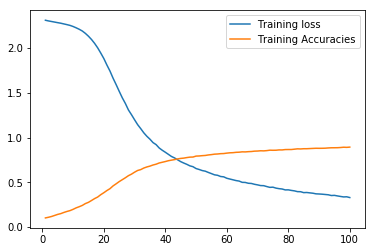

In [11]:
import matplotlib.pyplot as plt
plt.plot(range(1, epochs+1),[np.mean(teacher_train_history['avg_losses'][x]) for x in teacher_train_history['avg_losses']], label="Training loss")
plt.plot(range(1, epochs+1),[np.mean(teacher_train_history['avg_accuracies'][x]) for x in teacher_train_history['avg_accuracies']], label="Training Accuracies")
plt.legend()
plt.show()

In [12]:
for model in teachers:
    model.eval()

In [13]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1024)
criterion = nn.NLLLoss()

In [14]:
counter = 0
total_loss = 0
acc_count = 0

pred_list = []
label_list = []

for images, labels in testloader:    
    
    label_list.append(labels)
    images, labels = images.to(device), labels.to(device)
    
    temp_pred = []
    with torch.no_grad():
         for model in teachers:                 
            counter += images.size(0)
            
            logps = model(images)
            preds = (torch.exp(logps)).argmax(dim=1)
            temp_pred.append(preds.cpu())
            
            loss = criterion(logps, labels)
            total_loss += loss.item()
            acc_count += (preds==labels).sum().item()
    
    pred_list.append(temp_pred)
    
preds_tensor = torch.cat([torch.stack(preds, dim=0) for preds in pred_list], dim=1)
preds_counts = torch.from_numpy(np.apply_along_axis(lambda x: np.bincount(x, minlength=10), axis=0, arr=preds_tensor.numpy()))

aggregate_preds = preds_counts.argmax(dim=0)
labels          = torch.cat(label_list, dim=0)

aggregate_acc = (aggregate_preds == labels).float().mean().item()

print('\n')
print("Average Loss:", total_loss / counter)
print("Average Accuracy:", acc_count / counter)
print()
print("Aggregate Accuracy:", aggregate_acc)


/home/ayush/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()




Average Loss: 0.0003125503924265504
Average Accuracy: 0.906584

Aggregate Accuracy: 0.9379000067710876
